# Compare Models

Compares the heursitic model that was previously used and the logistic model that is 
currently used.  Two different versions of the logistic model are shown. The vanilla
model, which is what is currently in production and the multi-window model, that looks
at features at multiple window sizes, that is likely to replace the vanilla model in the
near future.

## Model History

### 1. Heuristic Model

This model was derived by observing that there were correlations between fishing
behaviour and several of the values present in AIS messages. In particular, the 
likelihood that a vessel was fishing tends to increase with the standard deviation of the speed ($\sigma_s$) and course ($\sigma_c$), but to decrease with mean speed. From this came the heursitic model:
$$
fishing\_score = \frac{2}{3}\left(\sigma_s + \sigma_c + \overline{\mathcal{S}}\right) \\
\overline{\mathcal{S}} = \text{mean}\left(1.0 - \min\left(1, speed/17\right)\right)
$$
where the means and standard deviations are computed over a one hour window.

The heuristic model performs reasonably well trawlers and longliners, but poorly for purse seiners.

### 2. Logistic Regression Models

A series of logistic regression models were then developed using the same three features
found in the *heursitic model*. In order to increase the expressiveness of the logistic model,
powers of the 3 base features are added to the features. Thus, the full feature vector consits of:
$$
\sigma_s, {\sigma_s}^2,\ldots, {\sigma_s}^n, \sigma_c, {\sigma_c}^2,\ldots, {\sigma_c}^n,
\overline{\mathcal{S}},{\overline{\mathcal{S}}}^2, \ldots {\overline{\mathcal{S}}}^n \\
$$

Note that that despite the odd form of \overline{\mathcal{S}}, from the point of view of the
logistic model, it's equivalent to the the mean of the speed capped at 17 knots 
($\text{mean}(\min(speed, 17))$).

#### Current Model

The current model is a logistic model using a single window of 12 hours with $n=6$. One model is
trained for all gear types. This model generally performs bettter than the heuristic model, but
still performs ratherpoorly on purse seiners.

####  Models in Progress

The next model, on the verge of being deployed, uses multiple time windows, ranging in duration
from one-half to twenty four hours, in order to have a richer feature set. In addition separate 
models are trained for each of the three primary gear types: longliners, trawlers and purse seines.
We are also experimenting with adding some other features. In particular, whether it is currently 
daylight appears to be a very useful feature for predicting purse seine fishing. These changes, taken
together, dramatically improve the performance, particularly of purse seiners.


### 3. Future Model Types

It is straightforward to convert the multi-window logistic model described above to a random forest or
neural net model. In early experiments, both of these model types offer slightly  performance 
relative to logistic model while at the same eliminating the need to augment the feature vector with 
powers of the base features.

We eventually plan to experiment with using convolutional or recurrent neural networks to find features
in the AIS data directly rather than hand engineering the features.




In [1]:
%matplotlib inline
import numpy as np
from vessel_scoring import data
from vessel_scoring.evaluate_model import train_model, compare_auc, compare_metrics
from IPython.core.display import display, HTML, Markdown
from sklearn import metrics

In [2]:
# Load training and test data
_, train_lline,  valid_lline, test_lline = data.load_dataset_by_vessel(
        'datasets/kristina_longliner.measures.npz')
_, train_trawl,  valid_trawl, test_trawl = data.load_dataset_by_vessel(
        'datasets/kristina_trawl.measures.npz')
_, train_pseine, valid_pseine, test_pseine = data.load_dataset_by_vessel(
        'datasets/kristina_ps.measures.npz')

test_lline_crowd, _, _, _ = data.load_dataset_by_vessel(
        "datasets/classified-filtered.measures.npz")

train = np.concatenate([train_trawl, train_lline, train_pseine, valid_lline, valid_trawl, valid_pseine])

IOError: [Errno 2] No such file or directory: 'datasets/classified-filtered.measures.npz'

## How much test data do we have

Our initial test and training data consisted of roughly a dozen different vessels of each type 
classified over a multi-year period by Kristina Boerder of Dalhousie University. One-Quarter of 
those are used for testing, so there is a relatively small number of different vessels in the test
sets. 

In addition, we are beginning to collect crowd sourced data for both testing and training. Some of the
early crowd sourced data, available for long liners only, is used as an additional test set in the examples
below.

In [3]:
for name, test_data in [("trawlers", test_trawl),
                        ("purse seiners", test_pseine),
                        ("longliners", test_lline),
                        ("crowd sourced longliners", test_lline_crowd)]:
    mmsi_count = len(set(test_data['mmsi']))
    pt_count = len(test_data)
    print("For {0} we have {1} test vessels with {2} test points".format(name, mmsi_count, pt_count))

For trawlers we have 3 test vessels with 5000 test points
For purse seiners we have 3 test vessels with 5000 test points
For longliners we have 2 test vessels with 5000 test points
For crowd sourced longliners we have 118 test vessels with 324166 test points


In [4]:
# Prepare the models

from vessel_scoring.legacy_heuristic_model import LegacyHeuristicModel
from vessel_scoring.logistic_model import LogisticModel

uniform_training_data = {'longliner': train, 
                         'longliner crowd' : train,
                         'trawler': train, 
                         'purse seiner': train}

test_data = {'longliner': test_lline, 
             'longliner crowd': test_lline_crowd,
             'trawler': test_trawl, 
             'purse seiner': test_pseine}

untrained_models = [
    ("Legacy", LegacyHeuristicModel(window=3600), 
         uniform_training_data),
    ('Logistic', LogisticModel(windows=[43200],
                                    order=6),
         uniform_training_data),
    ('Logistic (MW)', LogisticModel(windows=[1800, 3600, 10800, 21600, 43200, 86400],
                                    order=6), 
         uniform_training_data),
]

## Discrete Comparisons

The models output a numbers between 0 and 1 that correspond to how 
confident they are that there is fishing occuring. For
this first set of comparisons we treat predictions `>0.5`
as fishing and those `<=0.5` as nonfishing. This allows us to use
*precision*, *recall* and *f1-score* as metrics.

In [5]:
import imp, vessel_scoring.evaluate_model; imp.reload(vessel_scoring.evaluate_model)
from vessel_scoring.evaluate_model import (train_model, compare_auc, compare_pr,
                                           compare_metrics, compare_metrics_table)

for vessel_class in ["longliner", "longliner crowd", "trawler", "purse seiner"]:
    display(HTML("<h3>Comparison for {0}</h3>".format(vessel_class)))
    models = []
    for name, mdl, train_data in untrained_models:
        models.append((name, train_model(mdl, train_data[vessel_class])))
    display(Markdown(compare_metrics_table(models, test_data[vessel_class])))

|                    |     Precision      |       Recall       |      F1-score      |
|--------------------|--------------------|--------------------|--------------------|
|       Legacy       |       0.939        |       0.588        |       0.723        |
|      Logistic      |       0.969        |       0.745        |       0.843        |
|   Logistic (MW)    |       0.980        |       0.747        |       0.848        |


|                    |     Precision      |       Recall       |      F1-score      |
|--------------------|--------------------|--------------------|--------------------|
|       Legacy       |       0.857        |       0.685        |       0.761        |
|      Logistic      |       0.885        |       0.883        |       0.884        |
|   Logistic (MW)    |       0.897        |       0.825        |       0.859        |


|                    |     Precision      |       Recall       |      F1-score      |
|--------------------|--------------------|--------------------|--------------------|
|       Legacy       |       0.815        |       0.885        |       0.848        |
|      Logistic      |       0.878        |       0.936        |       0.906        |
|   Logistic (MW)    |       0.909        |       0.954        |       0.931        |


|                    |     Precision      |       Recall       |      F1-score      |
|--------------------|--------------------|--------------------|--------------------|
|       Legacy       |       0.059        |       1.000        |       0.111        |
|      Logistic      |       0.069        |       0.677        |       0.125        |
|   Logistic (MW)    |       0.111        |       0.839        |       0.197        |


## Precision - Recall Comparisons

One way to compare the models without picking a specific threshold is
to plot the precision versus recall of each model. 

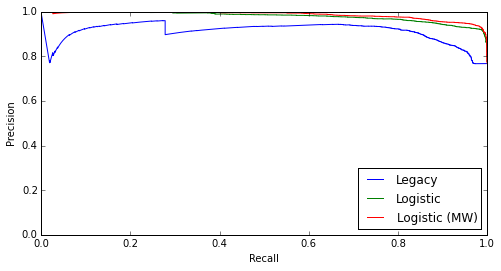

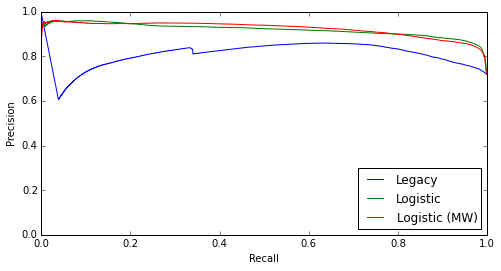

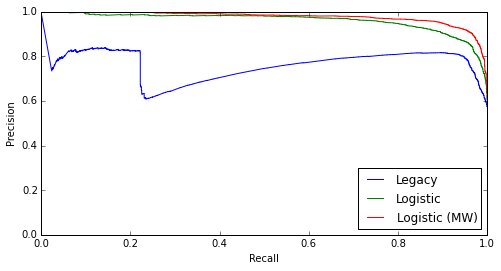

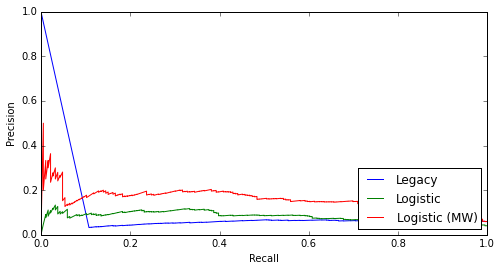

In [6]:
for vessel_class in ["longliner", "longliner crowd", "trawler", "purse seiner"]:
    display(HTML("<h3>Comparison for {0}</h3>".format(vessel_class)))
    models = []
    for name, mdl, train_data in untrained_models:
        models.append((name, train_model(mdl, train_data[vessel_class])))
    compare_pr(models, test_data[vessel_class])

## ROC Comparisons

Another approach to compare continuous output is the Receiver Operator Characteristic curve.
This curve plots *true positive rate* versus *false positive rate* and is useful for evaluating
what is possible with different threshold values.  The Area Under the Curve (AUC) is used as 
a metric in this case, with a larger AUC being better.

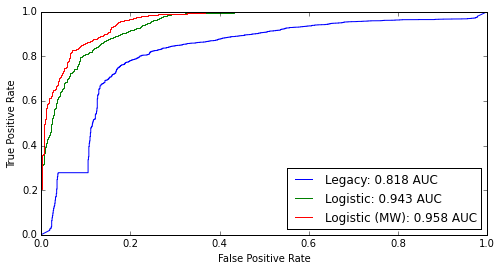

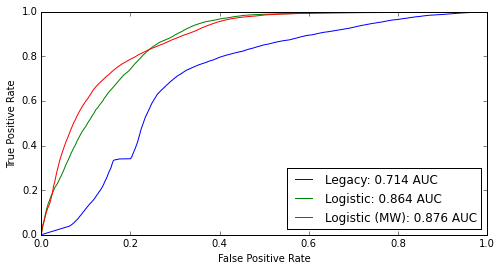

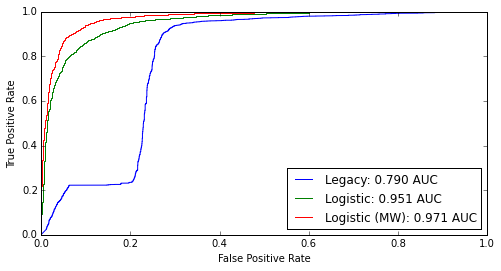

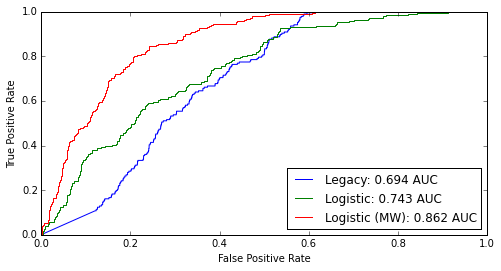

In [7]:
for vessel_class in ["longliner", "longliner crowd", "trawler", "purse seiner"]:
    display(HTML("<h3>Comparison for {0}</h3>".format(vessel_class)))
    models = []
    for name, mdl, train_data in untrained_models:
        models.append((name, train_model(mdl, train_data[vessel_class])))
    compare_auc(models, test_data[vessel_class])